Weather prediction dataset

ORIGINAL DATA TAKEN FROM:

EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 22-04-2021
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

-----------
Data collection selection and processing
----------

The initial meteorological data was retrieved from ECA&D [1] a project that makes available daily 
observations at meteorological stations throughout Europe and the Mediterranean. 18 different European 
cities or places were selected of which multiple daily observations were available through the 
years 2000 to 2010. Those where Basel (Switzerland), Budapest (Hungary), Dresden, Düsseldorf, 
Kassel, München (all  Germany), De Bilt and Maastricht (the Netherlands), Heathrow (UK), Ljubljana (Slovenia), 
Malmo and Stockholm (Sweden), Montélimar, Perpignan and Tours (France), Oslo (Norway), Roma (Italy), and 
Sonnblick (Austria). 

Recordings of daily meteorological observations for these 18 locations span different times, some contain 
collections that go back to the 19th century. Here, however, we only selected the time span from 
2000 to 2010 resulting in 3654 daily observations. The dataset is then constructed from all data of 
those 18 locations.

The data in addition consists of different observations. While all selected locations provide data 
for the variables ‘mean temperature’, ‘max temperature’, and ‘min temperature’, we also included 
data for the variables 'cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure', 'global_radiation', 
'precipitation', 'sunshine' wherever those were available. 

After collecting the data, very basic cleaning of the data was performed. Columns with > 5% invalid 
entries (“-9999”) were removed, columns with <= 5% invalid entries where kept but invalid entries 
were replaced by mean values. This resulted in 165 variables (or features) over the course of 3654 days.
Finally, we transformed several data units to achieve more similar ranges of the present values. 
This makes the data more suitable to be used for machine learning or deep learning even without 
additional processing. We deliberately did not chose to fully standardize the data because we 
wanted to keep the presented units and values as intuitively accessible as possible. Temperature are 
now given in degree Celsius, wind speed and gust in m/s, humidity in fraction of 100%, sea level 
pressure in 1000 hPa, global radiation in 100 W/m2, precipitation amounts in centimeter, sunshine in hours.


-----------
Physical units of the variables:
----------


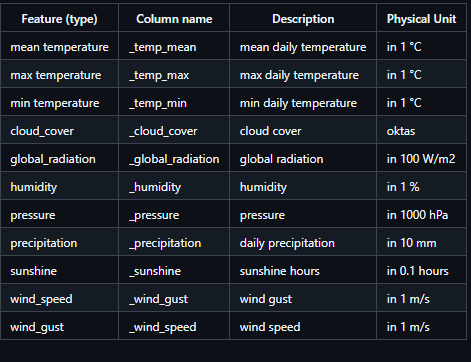eed	in 1 m/s

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import time
import pickle
from sklearn.model_selection import GridSearchCV

In [2]:
#Load Data

raw_data = pd.read_csv('weather_prediction_dataset.csv')
raw_data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


## Data Exploration

In [3]:
raw_data.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,5.104215,11.470635,3.677258,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,7.250744,8.950217,1.519866,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


In [4]:
raw_data.columns

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max', 'TOURS_wind_speed',
       'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
       'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min',
       'TOURS_temp_max'],
      dtype='object', length=165)

In [5]:
raw_data.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Columns: 165 entries, DATE to TOURS_temp_max
dtypes: float64(150), int64(15)
memory usage: 4.6 MB


## Data Cleaning
* No cleaning required as we have zero missing values

In [6]:
##Check For Missing Values
raw_data.isnull().sum() ## No missing values


DATE                      0
MONTH                     0
BASEL_cloud_cover         0
BASEL_humidity            0
BASEL_pressure            0
                         ..
TOURS_global_radiation    0
TOURS_precipitation       0
TOURS_temp_mean           0
TOURS_temp_min            0
TOURS_temp_max            0
Length: 165, dtype: int64

## Feature Selection
Main data file, tabular data, comma-separated CSV. Contains the data for different weather features (daily observations, see below for more details) for 18 European cities or places through the years 2000 to 2010.

The initial meteorological data was retrieved from ECA&D [1] a project that makes available daily observations at meteorological stations throughout Europe and the Mediterranean. 18 different European cities or places were selected of which multiple daily observations were available through the years 2000 to 2010. Those where Basel (Switzerland), Budapest (Hungary), Dresden, Düsseldorf, Kassel, München (all Germany), De Bilt and Maastricht (the Netherlands), Heathrow (UK), Ljubljana (Slovenia), Malmo and Stockholm (Sweden), Montélimar, Perpignan and Tours (France), Oslo (Norway), Roma (Italy), and Sonnblick (Austria).

Recordings of daily meteorological observations for these 18 locations span different times, some contain collections that go back to the 19th century. Here, however, we only selected the time span from 2000 to 2010 resulting in 3654 daily observations. The dataset is then constructed from all data of those 18 locations.

The data in addition consists of different observations. While all selected locations provide data for the variables ‘mean temperature’, ‘max temperature’, and ‘min temperature’, we also included data for the variables 'cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine' wherever those were availa

### Purpose Of Project
* For the purpose of this project we will only be working with the datas from MUENCHEN(Germany)ble.

In [7]:
muenchen_columns = ['DATE', 'MONTH', 'MUENCHEN_cloud_cover','MUENCHEN_wind_speed','MUENCHEN_wind_gust',
                    'MUENCHEN_humidity','MUENCHEN_pressure','MUENCHEN_global_radiation','MUENCHEN_precipitation',
                    'MUENCHEN_sunshine','MUENCHEN_temp_mean','MUENCHEN_temp_min','MUENCHEN_temp_max',]

In [8]:
muenchen_data = raw_data[muenchen_columns]
muenchen_data.head()

,DATE,MONTH,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_sunshine,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max
0,20000101,1,8,2.6,9.4,0.91,1.0273,0.20,0.20,0.0,1.7,-0.5,2.6
1,20000102,1,6,2.1,8.2,0.90,1.0321,0.66,0.00,6.1,1.9,-0.2,5.8
2,20000103,1,7,2.1,6.9,0.92,1.0317,0.28,0.00,0.4,-0.4,-3.3,0.9
3,20000104,1,6,2.7,11.7,0.75,1.0260,0.58,0.04,4.5,3.8,-2.8,6.6
4,20000105,1,5,3.3,13.2,0.87,1.0248,0.26,0.00,0.2,5.3,4.3,7.3


In [9]:
muenchen_data.describe()

,DATE,MONTH,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_sunshine,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.226054,2.792255,9.769814,0.741946,1.017450,1.426429,0.261700,5.219814,10.051587,5.997126,14.540285
std,2.874287e+04,3.450083,2.318547,1.315428,4.291187,0.132932,0.008226,0.983942,0.599618,4.594811,7.903211,7.055925,9.170164
min,2.000010e+07,1.000000,0.000000,0.700000,2.600000,0.200000,0.984000,0.190000,0.000000,0.000000,-12.900000,-16.400000,-9.900000
25%,2.002070e+07,4.000000,4.000000,1.900000,6.600000,0.650000,1.012600,0.580000,0.000000,0.700000,3.900000,0.600000,7.300000
50%,2.004567e+07,7.000000,6.000000,2.500000,8.700000,0.750000,1.017200,1.150000,0.010000,4.400000,10.400000,6.300000,14.800000
75%,2.007070e+07,10.000000,7.000000,3.300000,11.900000,0.840000,1.022500,2.230000,0.280000,8.900000,16.300000,11.675000,21.875000
max,2.010010e+07,12.000000,8.000000,10.400000,30.900000,1.000000,1.044000,3.650000,9.790000,15.700000,29.200000,22.000000,37.000000


## Data Visualization

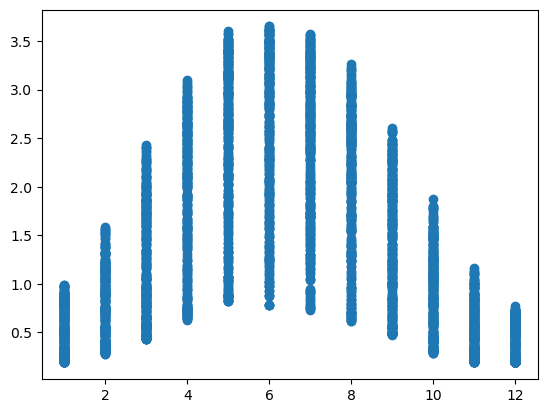

In [10]:
plt.scatter(muenchen_data['MONTH'],muenchen_data['MUENCHEN_global_radiation'])
plt.show()

* From The plot above the global Radiation is higher between May and July

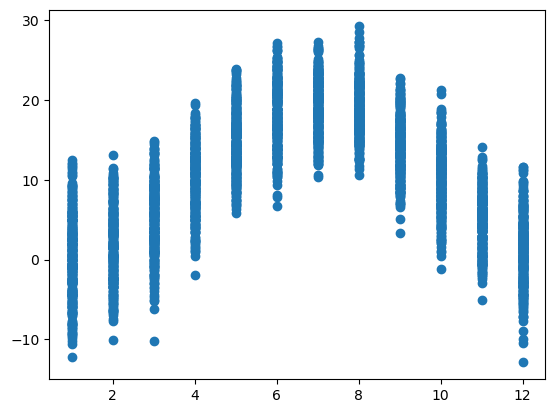

In [11]:
plt.scatter(muenchen_data['MONTH'],muenchen_data['MUENCHEN_temp_mean'])
plt.show()


* Temperature is also higher between june and august with the peak in august

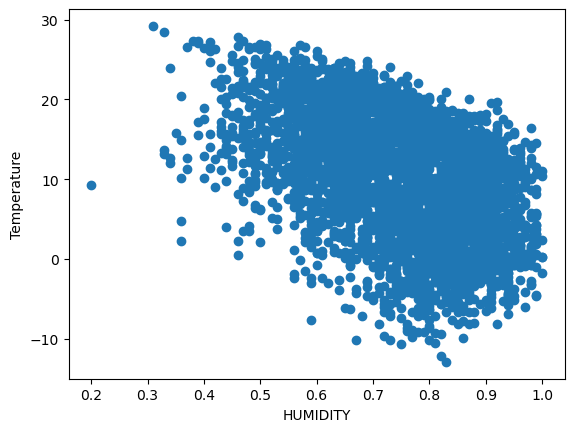

In [12]:
# Show Relationship Between Temperature and humidity
plt.scatter(muenchen_data['MUENCHEN_humidity'],muenchen_data['MUENCHEN_temp_mean'])
plt.xlabel('HUMIDITY')
plt.ylabel('Temperature')
plt.show()


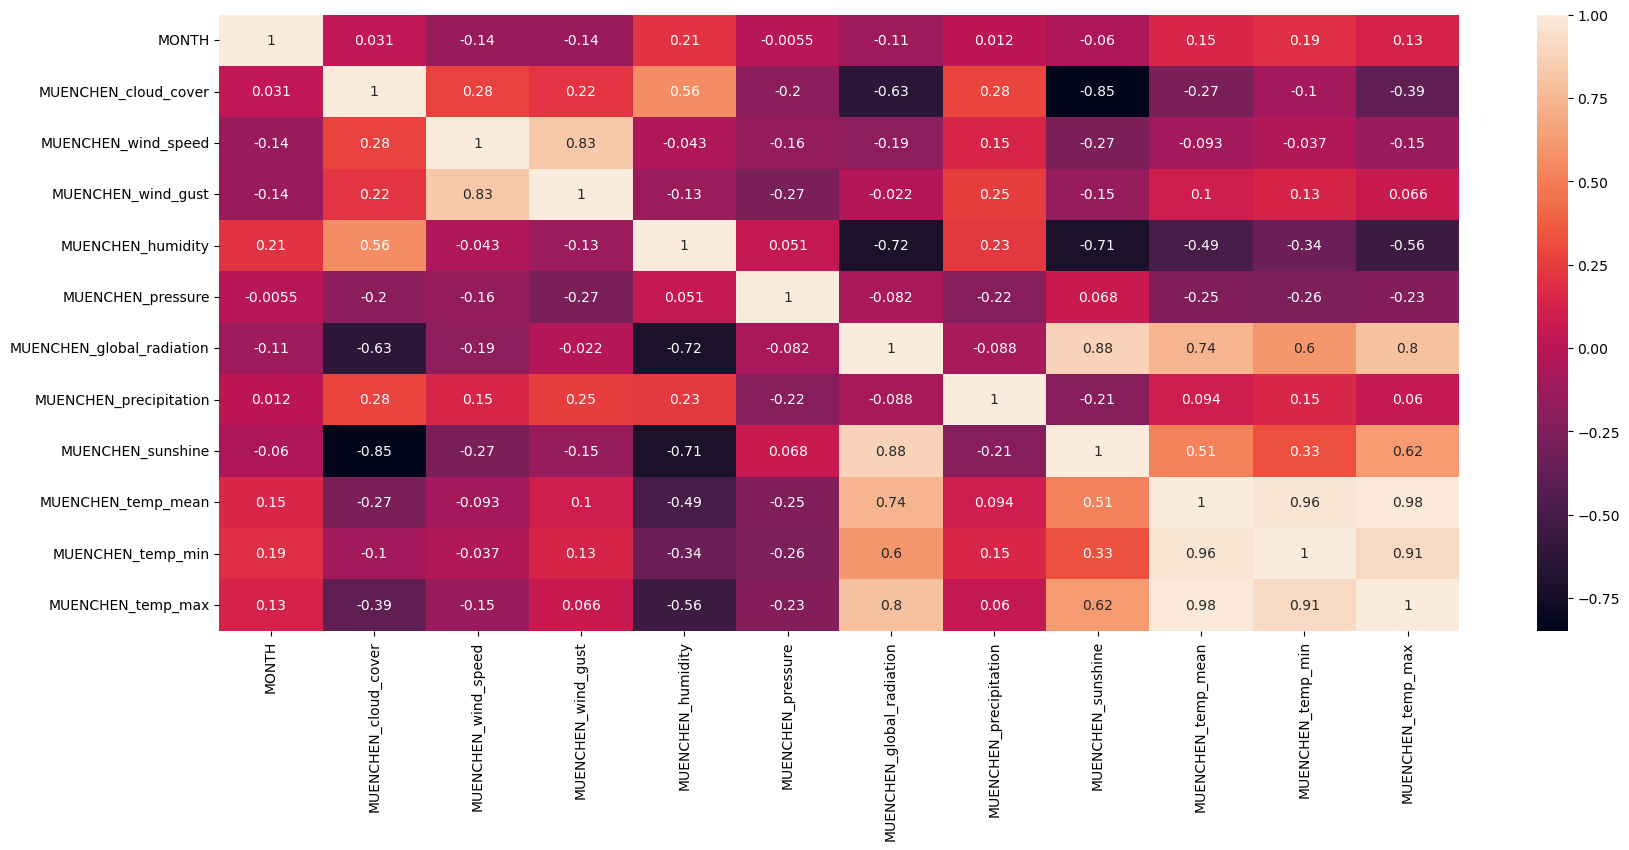

In [14]:
## HEATMAP OF RELATIONSHIPS BETWEEN DATA
numeric_columns = ['MONTH','MUENCHEN_cloud_cover','MUENCHEN_wind_speed','MUENCHEN_wind_gust',
                    'MUENCHEN_humidity','MUENCHEN_pressure','MUENCHEN_global_radiation','MUENCHEN_precipitation',
                    'MUENCHEN_sunshine','MUENCHEN_temp_mean','MUENCHEN_temp_min','MUENCHEN_temp_max']

correlation_data = muenchen_data[numeric_columns].corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_data,annot=True) 
plt.show()


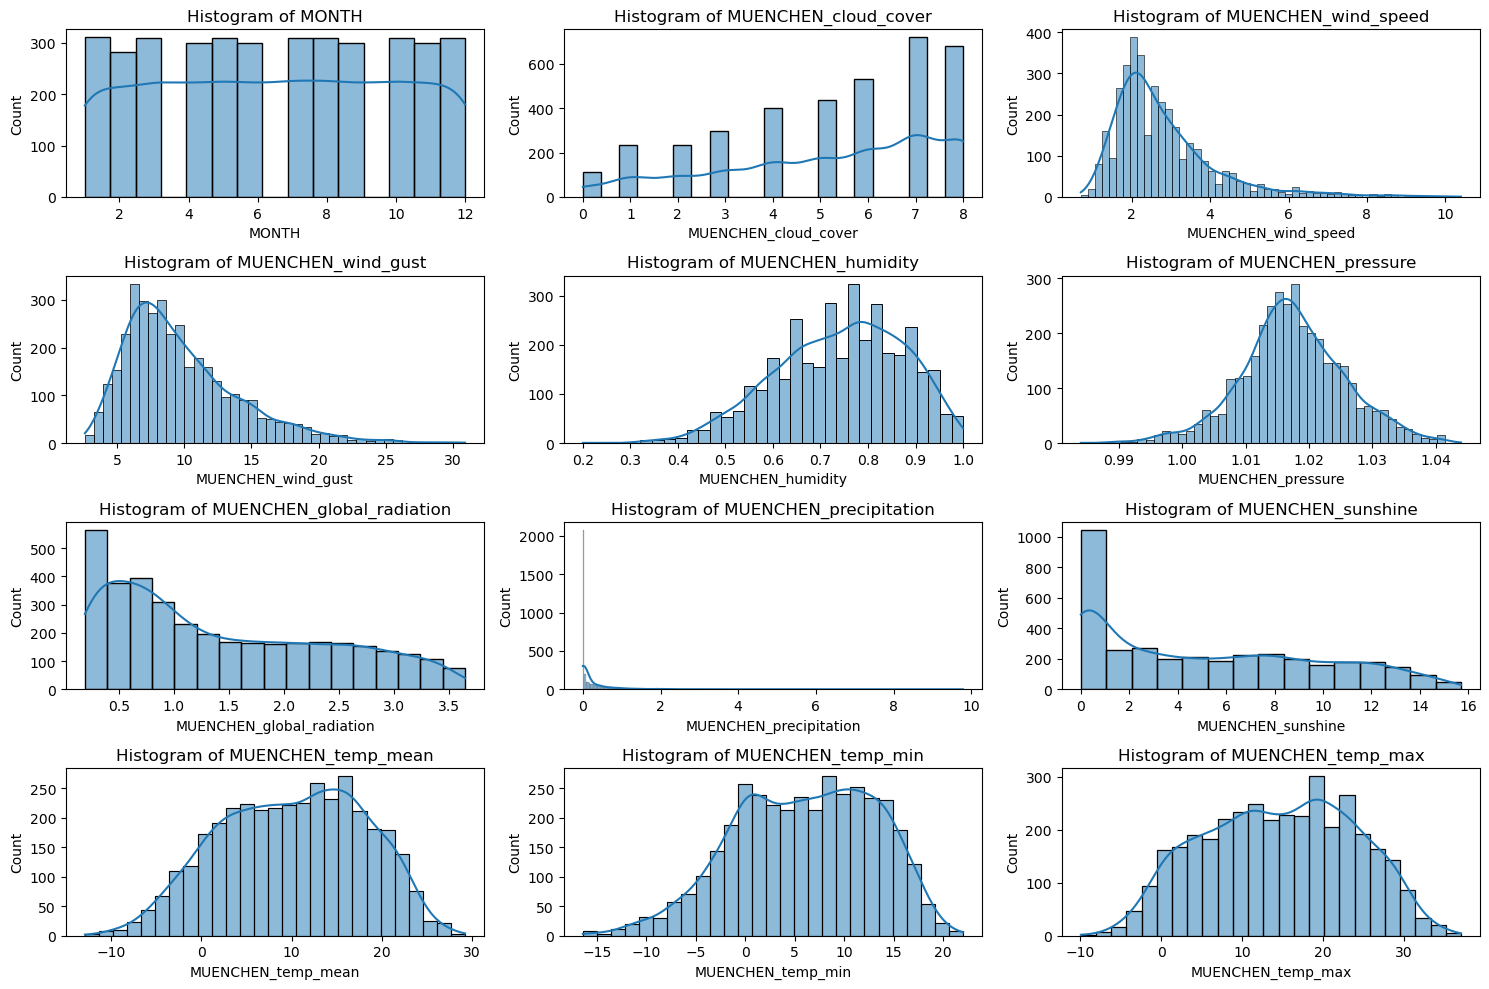

In [20]:
def histogramplot(dataframe):
    n_cols = 3  # columns per row 
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # number of rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust figure size based on the grid
    axes = axes.flatten()  
    
    # Plot histograms for each column
    for i, col in enumerate(numeric_columns):
        sns.histplot(dataframe[col], kde=True, ax=axes[i]) 
        axes[i].set_title(f'Histogram of {col}')  
    
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

histogramplot(muenchen_data)

## Feature Selection Note
* Base on the above Heatmap, Given that temperature is our target variable, the high correlation between temp_mean,temp_min and temp max is unhealthy for our model
* Hence we will be droping the temp_min and temp_max while we keep temp_mean as our  target variable
* And also since we won't be working with time series analysis we will also drop the date column

,MONTH,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_sunshine,MUENCHEN_temp_mean
0,1,8,2.6,9.4,0.91,1.0273,0.20,0.20,0.0,1.7
1,1,6,2.1,8.2,0.90,1.0321,0.66,0.00,6.1,1.9
2,1,7,2.1,6.9,0.92,1.0317,0.28,0.00,0.4,-0.4
3,1,6,2.7,11.7,0.75,1.0260,0.58,0.04,4.5,3.8
4,1,5,3.3,13.2,0.87,1.0248,0.26,0.00,0.2,5.3


## Data Normalization
* We will Normalize data using min max scaler

In [25]:
target = muenchen_data_final['MUENCHEN_temp_mean']
features = muenchen_data_final.drop('MUENCHEN_temp_mean', axis=1)

In [26]:
scaler_minmax = MinMaxScaler()
features_minmax_scaled = scaler_minmax.fit_transform(features)

with open('pickles/scaler_minmax.pkl', 'wb') as file:
        pickle.dump(scaler_minmax, file)
    
features_minmax_scaled_df = pd.DataFrame(features_minmax_scaled, columns=features.columns)

pca = PCA(n_components=5)  # Reduce to 5 components
features_minmax_scaled_pca = pca.fit_transform(features_minmax_scaled_df)
features_minmax_scaled_pca_df = pd.DataFrame(data=features_minmax_scaled_pca, columns=[f'PC_{i+1}' for i in range(features_minmax_scaled_pca.shape[1])])

features_minmax_scaled_df.head()

,MONTH,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_sunshine
0,0.0,1.000,0.195876,0.240283,0.8875,0.721667,0.002890,0.020429,0.000000
1,0.0,0.750,0.144330,0.197880,0.8750,0.801667,0.135838,0.000000,0.388535
2,0.0,0.875,0.144330,0.151943,0.9000,0.795000,0.026012,0.000000,0.025478
3,0.0,0.750,0.206186,0.321555,0.6875,0.700000,0.112717,0.004086,0.286624
4,0.0,0.625,0.268041,0.374558,0.8375,0.680000,0.020231,0.000000,0.012739


## Data Splitting

In [27]:
def split_data(features_scaled: pd.DataFrame, target: pd.Series) -> tuple:
    """
    Parameters features(pd.Dataframe) target(pd.Series)

    Return: A tupple of the split features

    Split Data into Train and test features with 30 Percent to test and 70 to training
    
    """
    train_features, test_val_features, train_label, test_val_label = train_test_split(features_scaled,
                                                                              target,
                                                                              test_size=0.40, 
                                                                              random_state=3)

    test_features, val_features, test_label, val_label = train_test_split(test_val_features,
                                                                              test_val_label,
                                                                              test_size=0.5, 
                                                                              random_state=3)
    print('Data Splitted successfully to Training, Testing and Validation set')
    return train_features,test_features,val_features,train_label,test_label,val_label
    


In [28]:
train_features,test_features,val_features,train_label,test_label,val_label = split_data(features_minmax_scaled_df,target)
train_features_pca,test_features_pca,val_features_pca,train_label_pca,test_label_pca,val_label_pca = split_data(features_minmax_scaled_pca_df,target)

Data Splitted successfully to Training, Testing and Validation set
Data Splitted successfully to Training, Testing and Validation set


## Model Building
* Comparing between data with PCA and Data without PCA

In [29]:
def train_regression_models(train_features: pd.DataFrame,
                            test_features: pd.DataFrame,
                            train_label: pd.Series,
                            test_label: pd.Series):

    """
    Parameters: 
    train_features -> Features to be used in training (pd.DataFrame)
    test_features -> Features for testing (pd.DataFrame)
    train_label -> Training labels (pd.Series)
    test_label -> Testing labels (pd.Series)
    
    Return: A tuple of predictions from all models.
    
    Train four regression models: Random Forest, XGBoost, Linear Regression, and Support Vector Regression.
    """
    # Model Initialization
    rf_model = RandomForestRegressor()  # Random Forest
    xgb_model = XGBRegressor()          # XGBoost
    lr_model = LinearRegression()        # Linear Regression
    svr_model = SVR()                   # Support Vector Regression
    
    print('Models Initialization Completed')
    
    # Models Training
    start_time = time.time()
    rf_model.fit(train_features, train_label)
    end_time = time.time()
    print(f'Random Forest Training Completed in {end_time - start_time:.2f} seconds')

    with open('pickles/random_forest_model.pkl', 'wb') as file:
        pickle.dump(rf_model, file)

    start_time = time.time()
    xgb_model.fit(train_features, train_label)
    end_time = time.time()
    print(f'XGBoost Training Completed in {end_time - start_time:.2f} seconds')

    with open('pickles/xgb.pkl', 'wb') as file:
        pickle.dump(xgb_model, file)

    start_time = time.time()
    lr_model.fit(train_features, train_label)
    end_time = time.time()
    print(f'Linear Regression Training Completed in {end_time - start_time:.2f} seconds')

    start_time = time.time()
    svr_model.fit(train_features, train_label)
    end_time = time.time()
    print(f'Support Vector Regression Training Completed in {end_time - start_time:.2f} seconds')
    
    print('Models Training Completed')

    # Models Predictions
    rf_predictions = rf_model.predict(test_features)
    xgb_predictions = xgb_model.predict(test_features)
    lr_predictions = lr_model.predict(test_features)
    svr_predictions = svr_model.predict(test_features)

    print('Models Predictions Completed')

    return rf_predictions, xgb_predictions, lr_predictions, svr_predictions

In [34]:


rf_predictions_pca, xgb_predictions_pca, lr_predictions_pca, svr_predictions_pca = train_regression_models(train_features_pca,
                                                                                                           val_features_pca,
                                                                                                           train_label_pca,
                                                                                                           val_label_pca)

rf_predictions, xgb_predictions, lr_predictions, svr_predictions = train_regression_models(train_features,
                                                                                           val_features,
                                                                                           train_label,
                                                                                           val_label)


Models Initialization Completed
Random Forest Training Completed in 6.32 seconds
XGBoost Training Completed in 0.75 seconds
Linear Regression Training Completed in 0.02 seconds
Support Vector Regression Training Completed in 0.95 seconds
Models Training Completed
Models Predictions Completed
Models Initialization Completed
Random Forest Training Completed in 7.45 seconds
XGBoost Training Completed in 0.44 seconds
Linear Regression Training Completed in 0.01 seconds
Support Vector Regression Training Completed in 0.85 seconds
Models Training Completed
Models Predictions Completed


## MOdel Evaluation
* Evaluation On RMSE, MAE, R2
* Comparing between data with PCA and Data without PCA

In [35]:
def evaluate_regression_models(test_labels: pd.Series, 
                                rf_predictions: pd.Series, 
                                xgb_predictions: pd.Series, 
                                lr_predictions: pd.Series, 
                                svr_predictions: pd.Series):
    
    """
    Parameters:
    - test_labels: True labels for the test set (pd.Series)
    - rf_predictions: Predictions from the Random Forest model (pd.Series)
    - xgb_predictions: Predictions from the XGBoost model (pd.Series)
    - lr_predictions: Predictions from the Linear Regression model (pd.Series)
    - svr_predictions: Predictions from the Support Vector Regression model (pd.Series)
    
    Return:
    - Prints evaluation metrics including MAE, RMSE, and R² for all models.
    """
    
    # Model Evaluation: Random Forest
    print('Random Forest Model Evaluation:')
    mae_rf = mean_absolute_error(test_labels, rf_predictions)
    rmse_rf = mean_squared_error(test_labels, rf_predictions, squared=False)
    r2_rf = r2_score(test_labels, rf_predictions)
    
    print(f'Mean Absolute Error (MAE): {mae_rf:.4f}')
    print(f'Root Mean Square Error (RMSE): {rmse_rf:.4f}')
    print(f'R-squared (R²): {r2_rf:.4f}')
    
    print('-' * 50)
    
    # Model Evaluation: XGBoost
    print('XGBoost Model Evaluation:')
    mae_xgb = mean_absolute_error(test_labels, xgb_predictions)
    rmse_xgb = mean_squared_error(test_labels, xgb_predictions, squared=False)
    r2_xgb = r2_score(test_labels, xgb_predictions)
    
    print(f'Mean Absolute Error (MAE): {mae_xgb:.4f}')
    print(f'Root Mean Square Error (RMSE): {rmse_xgb:.4f}')
    print(f'R-squared (R²): {r2_xgb:.4f}')
    
    print('-' * 50)

    # Model Evaluation: Linear Regression
    print('Linear Regression Model Evaluation:')
    mae_lr = mean_absolute_error(test_labels, lr_predictions)
    rmse_lr = mean_squared_error(test_labels, lr_predictions, squared=False)
    r2_lr = r2_score(test_labels, lr_predictions)
    
    print(f'Mean Absolute Error (MAE): {mae_lr:.4f}')
    print(f'Root Mean Square Error (RMSE): {rmse_lr:.4f}')
    print(f'R-squared (R²): {r2_lr:.4f}')
    
    print('-' * 50)

    # Model Evaluation: Support Vector Regression
    print('Support Vector Regression Model Evaluation:')
    mae_svr = mean_absolute_error(test_labels, svr_predictions)
    rmse_svr = mean_squared_error(test_labels, svr_predictions, squared=False)
    r2_svr = r2_score(test_labels, svr_predictions)
    
    print(f'Mean Absolute Error (MAE): {mae_svr:.4f}')
    print(f'Root Mean Square Error (RMSE): {rmse_svr:.4f}')
    print(f'R-squared (R²): {r2_svr:.4f}')

    print('Evaluation Completed')

In [37]:
print('PCA RESULT')
evaluate_regression_models(val_label_pca,rf_predictions_pca, xgb_predictions_pca, lr_predictions_pca, svr_predictions_pca)
print('Without PCA')
evaluate_regression_models(val_label,rf_predictions, xgb_predictions, lr_predictions, svr_predictions )



PCA RESULT
Random Forest Model Evaluation:
Mean Absolute Error (MAE): 2.7303
Root Mean Square Error (RMSE): 3.4670
R-squared (R²): 0.7963
--------------------------------------------------
XGBoost Model Evaluation:
Mean Absolute Error (MAE): 2.9698
Root Mean Square Error (RMSE): 3.7910
R-squared (R²): 0.7564
--------------------------------------------------
Linear Regression Model Evaluation:
Mean Absolute Error (MAE): 3.7925
Root Mean Square Error (RMSE): 4.7001
R-squared (R²): 0.6256
--------------------------------------------------
Support Vector Regression Model Evaluation:
Mean Absolute Error (MAE): 2.7256
Root Mean Square Error (RMSE): 3.4302
R-squared (R²): 0.8006
Evaluation Completed
Without PCA
Random Forest Model Evaluation:
Mean Absolute Error (MAE): 2.4959
Root Mean Square Error (RMSE): 3.1665
R-squared (R²): 0.8301
--------------------------------------------------
XGBoost Model Evaluation:
Mean Absolute Error (MAE): 2.6170
Root Mean Square Error (RMSE): 3.3581
R-squared

## Grid Search

In [115]:

def grid_search_tuning(train_features: pd.Series,
                       test_features: pd.Series,
                       val_features: pd.Series,
                       train_label: pd.Series,
                       test_label: pd.Series,
                       val_label: pd.Series):
    """
    Perform hyperparameter tuning for Random Forest models using GridSearchCV.
    
    Parameters:
    - train_features: Training features (pd.Series)
    - train_label: Training labels (pd.Series)
    - test_features: Testing features (pd.Series)
    - test_labels: Testing Labels (pd.Series)
    - val_features: Validation features (pd.Series)
    - val_label: Validation Labels (pd.Series)
    
    Returns:
    - Best hyperparameters for each model
    """

    # Random Forest Regressor Hyperparameter Tuning
    random_forest = RandomForestRegressor()
    random_forest_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    print('Starting Random Forest Hyperparameter Tuning...')
    start_time = time.time()
    random_forest_grid = GridSearchCV(estimator=random_forest,
                                       param_grid=random_forest_params,
                                       cv=5,
                                       scoring='neg_mean_squared_error') 
    
    random_forest_grid.fit(train_features, train_label)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Grid Search Hyperparameter Tuning for Random Forest completed in {time_taken:.2f} seconds')

    # Random Forest Predictions
    random_forest_grid_predictions = random_forest_grid.predict(test_features)
    print(f'Best Params for Random Forest: {random_forest_grid.best_params_}')
    print('Random Forest Model Evaluation On Testing Subset:')
    print(f'Mean Squared Error: {mean_absolute_error(test_label, random_forest_grid_predictions):.4f}')
    print(f'Root Mean Squared Error: {mean_squared_error(test_label, random_forest_grid_predictions, squared=False):.4f}')
    print(f'R-squared: {r2_score(test_label, random_forest_grid_predictions):.4f}')
    
    random_forest_grid_predictions_validation = random_forest_grid.predict(val_features)
    print('Random Forest Model Evaluation On Validation Subset:')
    print(f'Mean Absolute Error: {mean_absolute_error(val_label, random_forest_grid_predictions_validation):.4f}')
    print(f'Root Mean Squared Error: {mean_squared_error(val_label, random_forest_grid_predictions_validation, squared=False):.4f}')
    print(f'R-squared: {r2_score(val_label, random_forest_grid_predictions_validation):.4f}')

    with open('pickles/final_randomforest_model.pkl', 'wb') as file:
        pickle.dump(random_forest_grid, file)
    print('Random Forest Model Saved to Pickle Folder')



In [118]:
grid_search_tuning(train_features,
                   test_features,
                   val_features,
                   train_label,
                   test_label,
                   val_label)

Starting Random Forest Hyperparameter Tuning...
Grid Search Hyperparameter Tuning for Random Forest completed in 3078.90 seconds
Best Params for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Model Evaluation On Testing Subset:
Mean Squared Error: 2.5553
Root Mean Squared Error: 3.2469
R-squared: 0.8228
Random Forest Model Evaluation On Validation Subset:
Mean Absolute Error: 2.4680
Root Mean Squared Error: 3.1470
R-squared: 0.8321
Random Forest Model Saved to Pickle Folder


In [52]:
# Initialize the model with the best parameters
rf_model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=100
)

# Fit the model
rf_model.fit(train_features, train_label)


RandomForestRegressor(max_depth=10, min_samples_leaf=4)

In [53]:
# Make predictions
y_pred = rf_model.predict(val_features)

# Calculate RSME, R², and MAE
rmse = np.sqrt(mean_squared_error(val_label, y_pred))
r2 = r2_score(val_label, y_pred)
mae = mean_absolute_error(val_label, y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAE: {mae}")


RMSE: 3.1534004843466166
R²: 0.8314656345660644
MAE: 2.4780388074940345


In [54]:
import joblib
joblib.dump(rf_model, 'pickles/random_forest_model_main.pkl')


['pickles/random_forest_model_main.pkl']

In [46]:
muenchen_data_final.iloc[341]

MONTH                        5.0000
MUENCHEN_cloud_cover         7.0000
MUENCHEN_wind_speed          3.0000
MUENCHEN_wind_gust           8.6000
MUENCHEN_humidity            0.7800
MUENCHEN_pressure            1.0229
MUENCHEN_global_radiation    1.0700
MUENCHEN_precipitation       0.0700
MUENCHEN_sunshine            0.4000
MUENCHEN_temp_mean           9.5000
Name: 3411, dtype: float64